In [17]:
%env DATA_DIR=$HOME/datasets
%env EXPERIMENT_BASE=$HOME/experiments/ood_flows
%env LOG_LEVEL=INFO
%env BATCH_SIZE=64
%env OPTIM_LR=0.001
%env OPTIM_M=0.8
%env TRAIN_EPOCHS=100
%env EXC_RESUME=1
%env DATASET_NAME=QPM_species
%env MANIFOLD_D=512
%env MODEL_NAME=flow_mse
%env OOD_K=1

env: DATA_DIR=$HOME/datasets
env: EXPERIMENT_BASE=$HOME/experiments/ood_flows
env: LOG_LEVEL=INFO
env: BATCH_SIZE=64
env: OPTIM_LR=0.001
env: OPTIM_M=0.8
env: TRAIN_EPOCHS=100
env: EXC_RESUME=1
env: DATASET_NAME=QPM_species
env: MANIFOLD_D=512
env: MODEL_NAME=flow_mse
env: OOD_K=1


In [18]:
import lightning.pytorch as pl
import numpy as np
import torch
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers.wandb import WandbLogger

from config import Config, load_config
from datasets import get_data
from models import get_model

In [19]:
# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

config = load_config()

In [20]:
# initialize data attributes and loaders
config.load_data()
config.print_labels()
dm = config.datamodule
assert dm

In [21]:
dm.setup("train")
dm.setup("val")
dm.setup("test")

Dataset type train label type: species
Loaded 375443 images
Dataset type val label type: species
Loaded 48562 images
Dataset type test label type: species
Loaded 48790 images
Performing ind/ood split


100%|██████████| 375443/375443 [00:06<00:00, 59950.78it/s]


Train - OK


100%|██████████| 48562/48562 [00:00<00:00, 60001.32it/s]


Val - OK


100%|██████████| 48790/48790 [00:00<00:00, 59863.36it/s]

Test - OK
Performed ind/ood split
364215 47159 47386 14035


In [22]:
model = config.get_model()

In [23]:
# model id for each ood_k
model_ids = ['yaqvd9bh', 'jk9mupnp', 'k9ssmq8z', 'q81qsrhl', '419mcv6g']
model_id = model_ids[config.ood[0]]
print(model_id)

jk9mupnp


In [24]:
from pathlib import Path
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/uq_project/model-{model_id}:best")
model = model.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [25]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
predict_loader = dm.predict_dataloader()

In [26]:
from models.common import edl_probs
from tqdm.auto import tqdm

ind_v_norms = []
ood_v_norms = []

for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y = batch
    x = x.float().cuda()
    y = y.long().cuda()
    v, z, x_m, logits = model(x)
    v_norms = v.detach().flatten(start_dim=1).norm(dim=-1).cpu().numpy()
    ind_v_norms.extend(v_norms)
print("test InD - OK")

for batch_idx, batch in enumerate(tqdm(predict_loader)):
    x, y = batch
    x = x.float().cuda()
    y = y.long().cuda()
    v, z, x_m, logits = model(x)
    v_norms = v.detach().flatten(start_dim=1).norm(dim=-1).cpu().numpy()
    ood_v_norms.extend(v_norms)
print("test OoD - OK")
    
ind_v_norms = np.array(ind_v_norms)
ood_v_norms = np.array(ood_v_norms)

100%|██████████| 741/741 [00:23<00:00, 31.32it/s]


test InD - OK


100%|██████████| 220/220 [00:07<00:00, 29.70it/s]


test OoD - OK


In [27]:
ind_v_norms_scaled = np.tanh(ind_v_norms)
ood_v_norms_scaled = np.tanh(ood_v_norms)

print(ind_v_norms.mean(), ind_v_norms.std())
print(ood_v_norms.mean(), ood_v_norms.std())

0.0024515965 0.001303485
0.0026759845 0.0074544153


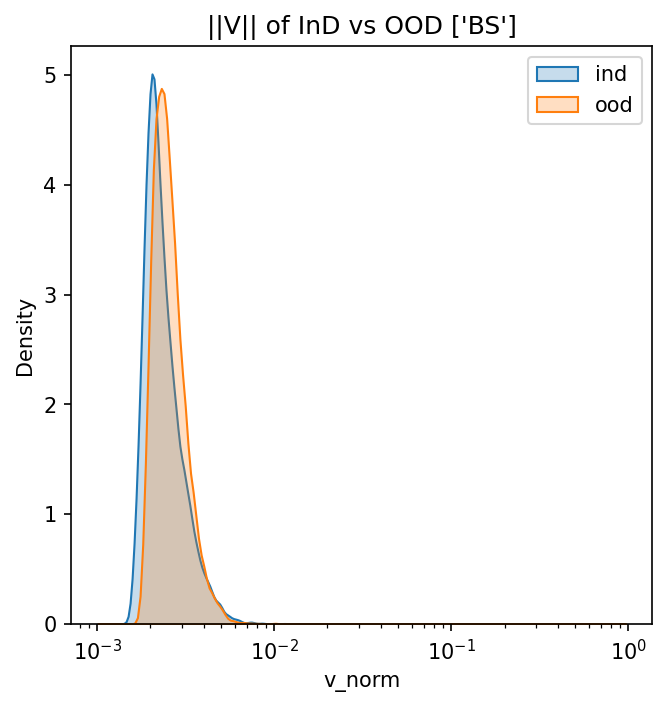

In [28]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 150

data_ind = pd.DataFrame(dict(v_norm=ind_v_norms))
data_ood = pd.DataFrame(dict(v_norm=ood_v_norms))

sns.kdeplot(data=data_ind, x="v_norm", log_scale=True, fill=True, label='ind')
sns.kdeplot(data=data_ood, x="v_norm", log_scale=True, fill=True, label='ood')

plt.title(f"||V|| of InD vs OOD {config.get_ood_labels()}")
plt.legend()
plt.savefig(f"assets/figures/qpm_species_flow_mse_M512_ood_{config.ood_k}.png")